# Prompt Collection - Static Analysis

### 🔨 **Setup**

In [39]:
# Use the Language.build_library method to compile these into a library that's usable from Python. 
# This function will return immediately if the library has already been compiled since the last 
# time its source code was modified:

from tree_sitter import Language, Parser
import os
import re
import matplotlib.pyplot as plt

# Ensuring that the library is compiled each time this cell is run.
if os.path.exists("build/my-languages.so"):
    os.remove("build/my-languages.so")

Language.build_library(
    # Store the library in the `build` directory
    "build/my-languages.so",
    # Include one or more languages
    ["vendor/tree-sitter-python"],
)

True

### 🔍 **Parser**

In [35]:
def parse(filename):
    PY_LANGUAGE = Language('build/my-languages.so', 'python')
    parser = Parser()
    parser.set_language(PY_LANGUAGE)
    result = []

    with open(filename, "rb") as f:
        tree = parser.parse(f.read())

    # query = PY_LANGUAGE.query("""
    #     (expression_statement
    #         (assignment
    #             left: (identifier) @var.name
    #             right: (_) @var.value
    #             (#eq? @var.name "prompt")
    #         )
    #     )
    # """)

    query = PY_LANGUAGE.query("""
        (expression_statement
            (assignment
                left: (identifier) @var.name
                right: (string) @var.value
            )
        )
    """)

    for usage in query.captures(tree.root_node):
        if usage[1] == "var.value":
            # heuristic, check if length of string is >= 30 chars, if so then it's probably a prompt
            # res = usage[0].text.decode("utf-8") + "\n"
            # if len(res) >= 30:
            #     result += res

            # heuristic, check if string has a newline in it, if so then it's probably a prompt
            res = usage[0].text.decode("utf-8")
            if "\n" in res:
                result.append(res)

            # res = usage[0].text.decode("utf-8") + "\n"
            # result += res

    return result

# Test the parser
print(parse("/Users/ishan/Desktop/Projects/prompt-linter/parse_data/repos/kaarthik108~snowChat/template.py"))

['"""You are an AI chatbot having a conversation with a human.\n\nChat History:\\"""\n{chat_history}\n\\"""\nHuman: \\"""\n{question}\n\\"""\nAssistant:"""', '""" \nYou\'re an AI assistant specializing in data analysis with Snowflake SQL. When providing responses, strive to exhibit friendliness and adopt a conversational tone, similar to how a friend or tutor would communicate.\n\nWhen asked about your capabilities, provide a general overview of your ability to assist with data analysis tasks using Snowflake SQL, instead of performing specific SQL queries. \n\nBased on the question provided, if it pertains to data analysis or SQL tasks, generate SQL code that is compatible with the Snowflake environment. Additionally, offer a brief explanation about how you arrived at the SQL code. If the required column isn\'t explicitly stated in the context, suggest an alternative using available columns, but do not assume the existence of any columns that are not mentioned. Also, do not modify the 

### 📦 Storing Repo Files for Reliable Parsing

Feel free to run this cell multiple times if there were exceptions when downloading some files.

It will only download files that are not already present in the `repos` folder, and fill up the gaps.

In [4]:
import json, requests

# Import Raw URLs
with open("../data/repo_to_rawFileURL_>=4stars.json", "r") as file:
    repos_prompts = json.load(file)


# NOTE: Refer to this stackoverflow post for issues with requests: 
# https://stackoverflow.com/questions/62599036/python-requests-is-slow-and-takes-very-long-to-complete-http-or-https-request

root_dir = "repos"
if not os.path.exists(root_dir):
    os.mkdir(root_dir)

# Note: Using '~' instead of '/' as a delimiter for file/dir names 
# (because I'm not creative enough to come up with a better solution)
for repo in repos_prompts:
    repo_path = os.path.join(root_dir, repo.replace("/", "~"))
    if not os.path.exists(repo_path):
        os.mkdir(repo_path)

    for url in repos_prompts[repo]:
        filename = url.split("/")[6:]
        filename = "~".join(filename)
        file_path = os.path.join(repo_path, filename)
        
        if not os.path.exists(file_path):
            try:
                r = requests.get(url, timeout=1)
                # Exception thrown before file is created. 
                # So, if file exists, it's safe to assume that it's been downloaded successfully.
                if r.status_code == 200:
                    with open(file_path, "w") as f:
                        f.write(r.text)
                else:
                    print("Error: ", r.status_code, repo_path, filename)
            except Exception as e:
                print(e)
                print("Error: ", repo_path, filename)

print("Done")

Done


/Users/ishan/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


### 🧠 Sanity Check

In [5]:
# Count the number of repos in the repos directory
assert len(os.listdir(root_dir)) == len(repos_prompts)
print("Number of repos: ", len(os.listdir(root_dir)), "; Expected 372 for repos >=4stars")

# Count the number of files in each repo
count = 0
for repo in repos_prompts:
    repo_path = os.path.join(root_dir, repo.replace("/", "~"))
    assert len(os.listdir(repo_path)) == len(repos_prompts[repo])
    for file in os.listdir(repo_path):
        with open(os.path.join(repo_path, file), "r") as f:
            assert f.read() != ""  # Complain if file is empty
    count += len(os.listdir(repo_path))
print("Total number of files: ", count, "; Expected 1444 for repos >=4stars")

Number of repos:  372 ; Expected 372 for repos >=4stars
Total number of files:  1444 ; Expected 1444 for repos >=4stars


### 📊 **Prompt Collection** - Parsing

Guidance prompts:  127
Parser Returns result for 1127 prompts
Unique inputs per repo:  {3: 97, 1: 117, 8: 8, 2: 187, 4: 52, 0: 42, 6: 13, 7: 4, 5: 29, 9: 6, 14: 3, 10: 1, 11: 1}
Unique inputs per prompt:  {2: 393, 1: 283, 0: 234, 5: 25, 3: 123, 4: 54, 6: 9, 8: 2, 7: 2, 9: 2}
Input frequency:  {'chat_history': 71, 'question': 266, 'context': 195, 'tools': 13, 'tool_names': 26, 'history': 61, 'input': 121, 'agent_scratchpad': 53, 'dialect': 5, 'query_str': 6, 'task': 21, 'context_str': 4, 'tool_description': 3, 'tool_input': 1, 'summaries': 32, 'query': 57, "result['answer']": 3, "result['sources']": 3, 'text': 54, 'ABOUT_ME': 1, 'CONTEXT': 1, 'QUESTION': 11, 'Claim': 2, 'PASSAGE': 2, 'TOPIC': 2, 'entities': 5, 'summary': 20, 'new_lines': 4, 'entity': 16, 'statement': 2, 'assertions': 2, 'checked_assertions': 2, 'browser_content': 2, 'objective': 5, 'url': 2, 'previous_command': 2, 'result': 14, 'answer': 24, 'COMP_WORDS[*]': 1, 'response': 14, 'existing_answer': 3, 'human_input': 9, 'sy

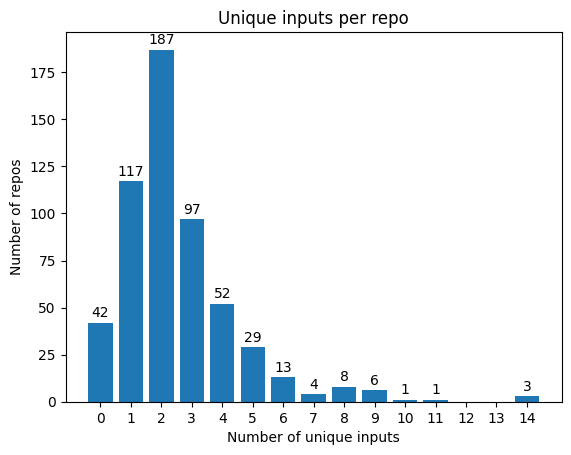

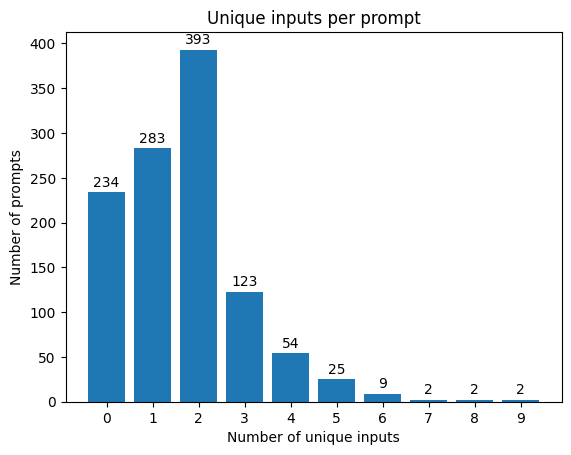

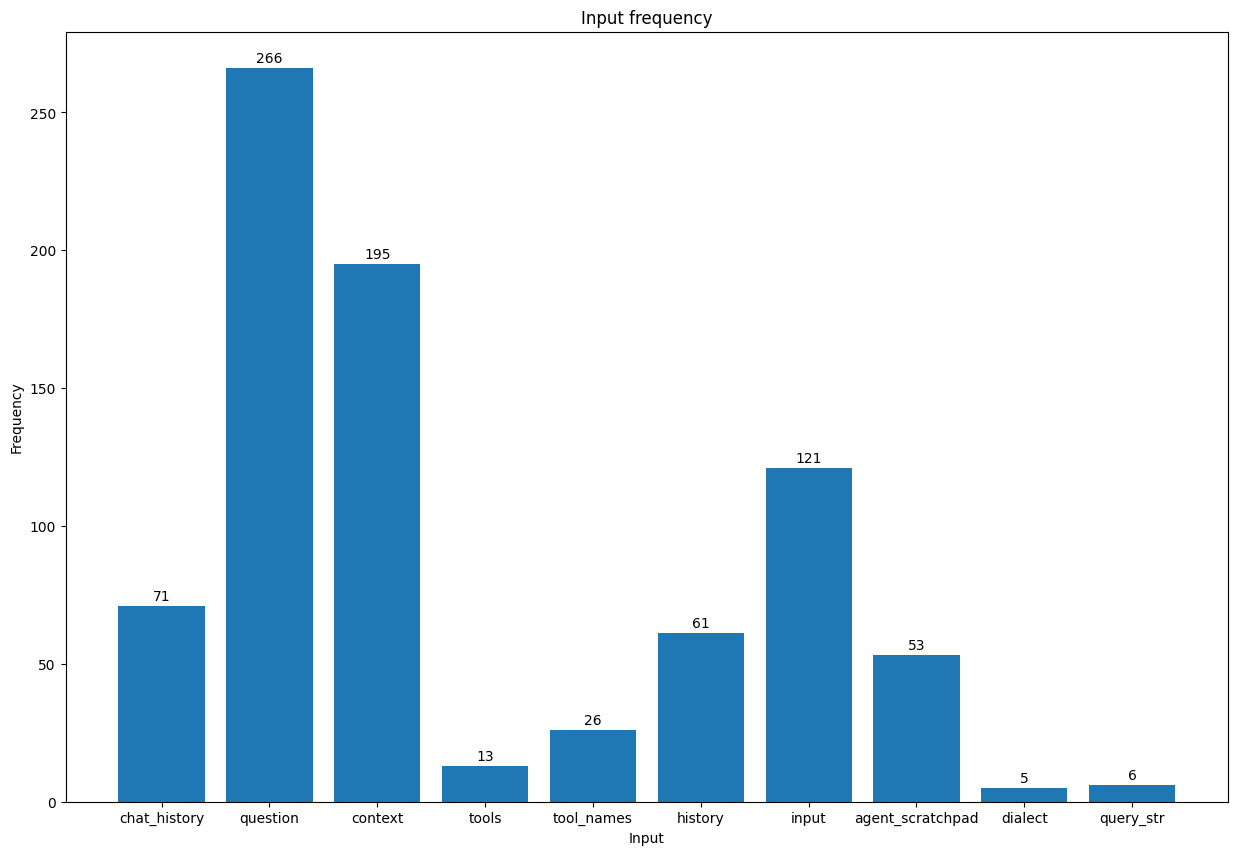

In [79]:
root_dir = "repos"

unique_inputs_per_repo = {}
unique_inputs_per_prompt = {}
input_frequency = {}

count = 0
guidance = 0
for repo in os.listdir(root_dir):
    repo_path = os.path.join(root_dir, repo)
    for file in os.listdir(repo_path):
        file_path = os.path.join(repo_path, file)
        try:
            unique_inputs_repo = set()
            hasPrompt = False
            prompts = parse(file_path)
            for prompt in prompts:
                if prompt != "":
                    hasPrompt = True
                    unique_inputs_prompt = set()
                    count += 1
                    # print("Repo: ", repo, "; File: ", file)
                    # print(prompt)

                    inputs = re.findall(r"\{.*?\}", prompt)

                    for i in range(len(inputs)):
                        inputs[i] = inputs[i][1:-1]

                        if '.' in inputs[i] or len(inputs[i]) > 20 or inputs[i] == "":
                            continue

                        if inputs[i][0] == '{' or inputs[i][-1] == '}':
                            # print("Repo: ", repo, "; File: ", file)
                            # print(prompt)
                            guidance += 1
                            continue

                        unique_inputs_repo.add(inputs[i])
                        unique_inputs_prompt.add(inputs[i])

                        if inputs[i] not in input_frequency:
                            input_frequency[inputs[i]] = 1
                        else:
                            input_frequency[inputs[i]] += 1

                    if len(unique_inputs_prompt) not in unique_inputs_per_prompt:
                        unique_inputs_per_prompt[len(unique_inputs_prompt)] = 1
                    else:
                        unique_inputs_per_prompt[len(unique_inputs_prompt)] += 1

                    # if len(unique_inputs_prompt) >= 9:
                    #     print("Repo: ", repo, "; File: ", file)
                    #     print(prompt)
            
            if hasPrompt:
                if len(unique_inputs_repo) not in unique_inputs_per_repo:
                    unique_inputs_per_repo[len(unique_inputs_repo)] = 1
                else:
                    unique_inputs_per_repo[len(unique_inputs_repo)] += 1

        except Exception as e:
            print(e)
            print("Error: ", repo_path, file_path)

# print(sum(unique_inputs_per_prompt.values()))
print("Guidance prompts: ", guidance)
print(f"Parser Returns result for {count} prompts")
print("Unique inputs per repo: ", unique_inputs_per_repo)
print("Unique inputs per prompt: ", unique_inputs_per_prompt)
print("Input frequency: ", input_frequency)

# Plotting

# Plotting unique inputs per repo
fig, ax = plt.subplots()
bar = ax.bar(unique_inputs_per_repo.keys(), unique_inputs_per_repo.values())
plt.xticks(range(0, max(unique_inputs_per_repo.keys()) + 1))
plt.xlabel("Number of unique inputs")
plt.ylabel("Number of repos")
plt.title("Unique inputs per repo")
ax.bar_label(bar, padding=2)
plt.show()

# Plotting unique inputs per prompt
fig, ax = plt.subplots()
bar = ax.bar(unique_inputs_per_prompt.keys(), unique_inputs_per_prompt.values())
plt.xticks(range(0, max(unique_inputs_per_prompt.keys()) + 1))
plt.xlabel("Number of unique inputs")
plt.ylabel("Number of prompts")
plt.title("Unique inputs per prompt")
ax.bar_label(bar, padding=2)
plt.show()

# Plotting input frequency (only first 10 for now)
fig, ax = plt.subplots()
fig.set_figwidth(15)
fig.set_figheight(10)
bar = ax.bar(list(input_frequency.keys())[:10], list(input_frequency.values())[:10])
plt.xticks(range(0, 10))
plt.xlabel("Input")
plt.ylabel("Frequency")
plt.title("Input frequency")
ax.bar_label(bar, padding=2)
plt.show()
